### statsmodels 基本介绍
statsmodels 是一个Python库，用于拟合多种统计模型，执行统计测试以及数据探索和可视化。statsmodels包含更多的“经典”频率学派统计方法,包含在statsmodels中的一些模型：
- 线性模型，广义线性模型和鲁棒线性模型
- 线性混合效应模型
- 方差分析（ANOVA）方法
- 时间序列过程和状态空间模型
- 广义的矩量法

ARIMA模型（英语：Autoregressive Integrated Moving Average model），差分整合移动平均自回归模型，又称整合移动平均自回归模型（移动也可称作滑动），是时间序列预测分析方法之一。ARIMA(p，d，q)中，AR是“自回归”，p为自回归项数；MA为“滑动平均”，q为滑动平均项数，d为使之成为平稳序列所做的差分次数（阶数）。“差分”一词虽未出现在ARIMA的英文名称中，却是关键步骤。

参考：https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima

### 导入包

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

### 导入数据并打印头尾

In [4]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv')
df.head(5).append(df.tail(5))

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4572252,1600041360,10324.35,10325.89,10324.35,10325.89,0.081143,837.754188,10324.419779
4572253,1600041420,10331.41,10331.97,10326.68,10331.97,0.572817,5918.028741,10331.444396
4572254,1600041480,10327.20,10331.47,10321.33,10331.47,2.489909,25711.238323,10326.175283
4572255,1600041540,10330.02,10334.78,10328.64,10334.78,4.572660,47253.747619,10333.972651
4572256,1600041600,10338.82,10338.82,10332.37,10332.37,1.292006,13349.565122,10332.429402


### 对数据进行重采样

In [5]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# 对按天对数据取平均值
df.index = df.Timestamp
df = df.resample('D').mean()

# 对按月对数据取平均值
df_month = df.resample('M').mean()

# 对按年对数据取平均值
df_year = df.resample('A-DEC').mean()

# 对按季度对数据取平均值
df_Q = df.resample('Q-DEC').mean()

让 pyplot 显示中文标题

In [7]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

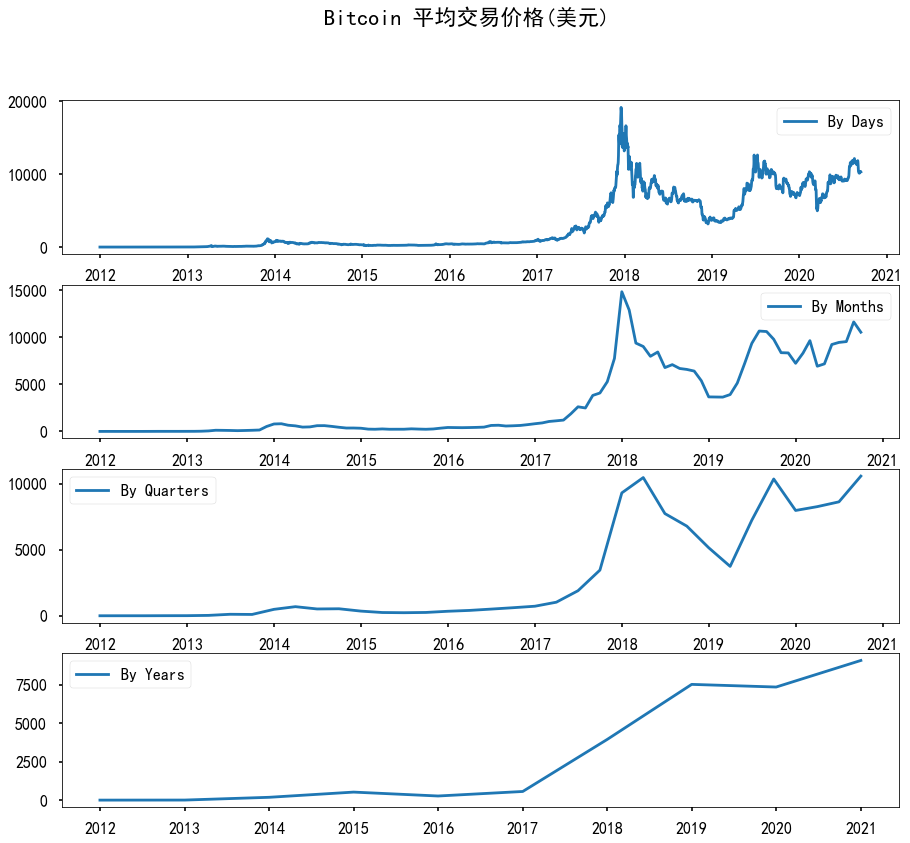

In [11]:
fig = plt.figure(figsize=[15, 13])
plt.suptitle('Bitcoin 平均交易价格(美元)', fontsize=22)

plt.subplot(411)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(412)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(413)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(414)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Bitcoin 价格变化趋势及残差

Dickey–Fuller test: p=0.617866


<Figure size 1080x504 with 0 Axes>

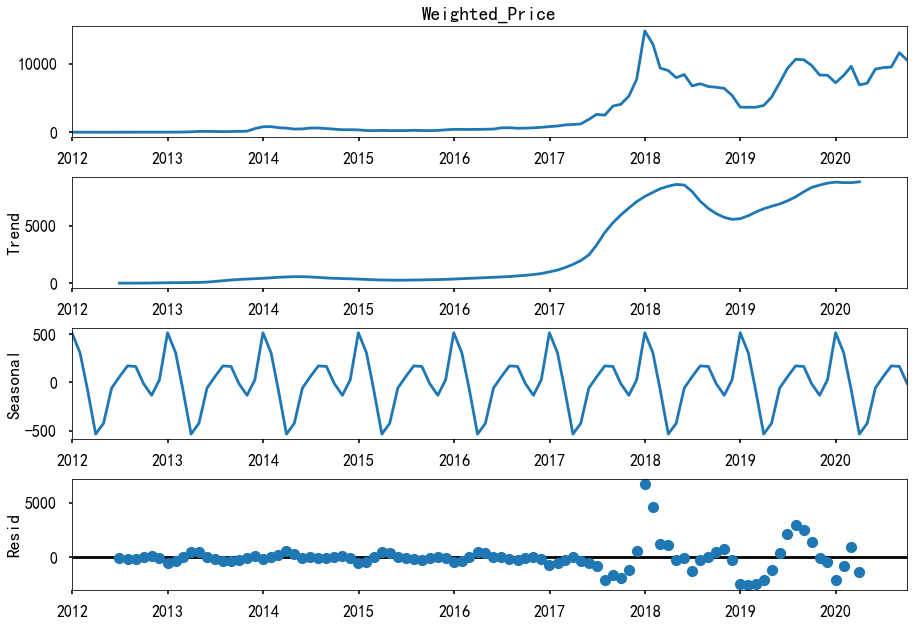

In [27]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [28]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.617866


In [29]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.288535


Dickey–Fuller test: p=0.000002


<Figure size 1080x504 with 0 Axes>

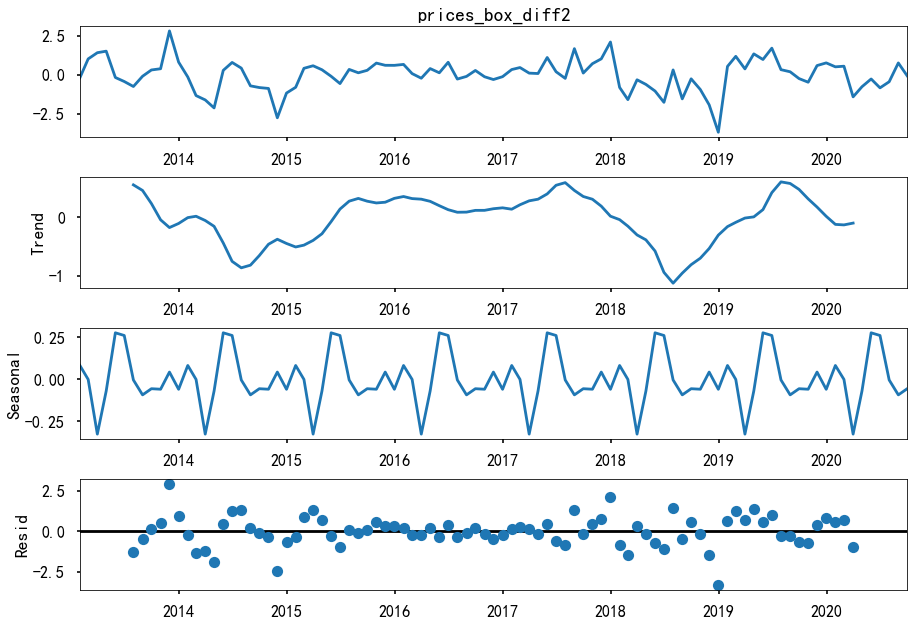

In [19]:
# Regular differentiation

df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7),)

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

自相关图（Autocorrelation）与偏相关图(Partial Correlation) 


https://bbs.pinggu.org/thread-3096618-1-1.html

https://support.minitab.com/zh-cn/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/

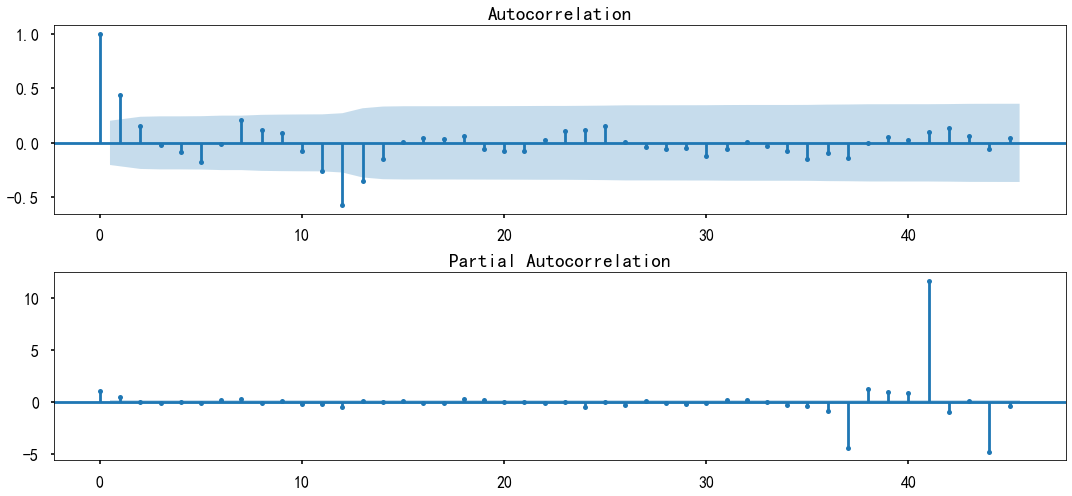

In [24]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

模型选择

In [26]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [41]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
11  (0, 1, 2, 1)  198.825567
23  (1, 0, 2, 1)  198.882307
19  (1, 0, 0, 1)  199.158304
21  (1, 0, 1, 1)  199.434530
7   (0, 1, 0, 1)  199.518376
                                     SARIMAX Results                                      
Dep. Variable:                 Weighted_Price_box   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -94.413
Date:                            Fri, 01 Jan 2021   AIC                            198.826
Time:                                    19:07:09   BIC                            211.489
Sample:                                12-31-2011   HQIC                           203.939
                                     - 09-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


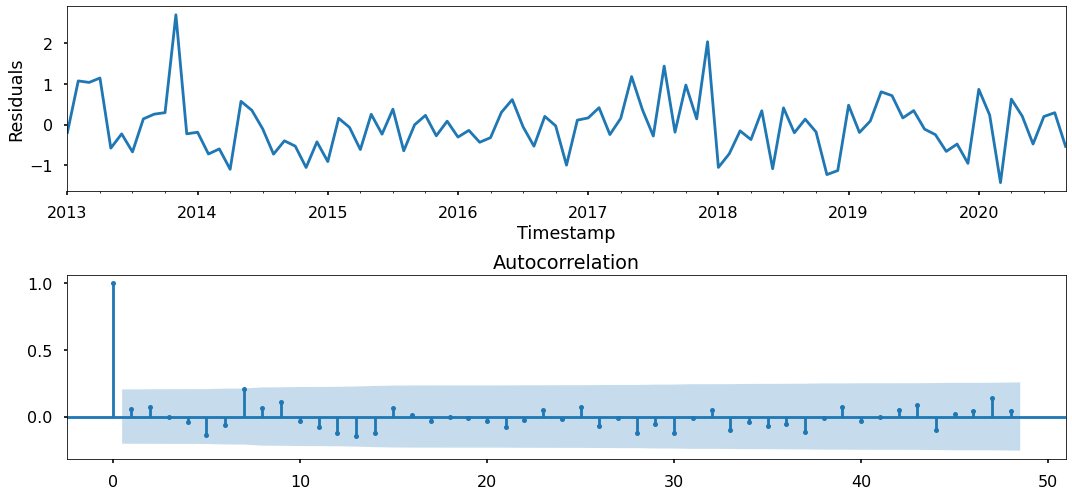

In [42]:
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [32]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

预测结果

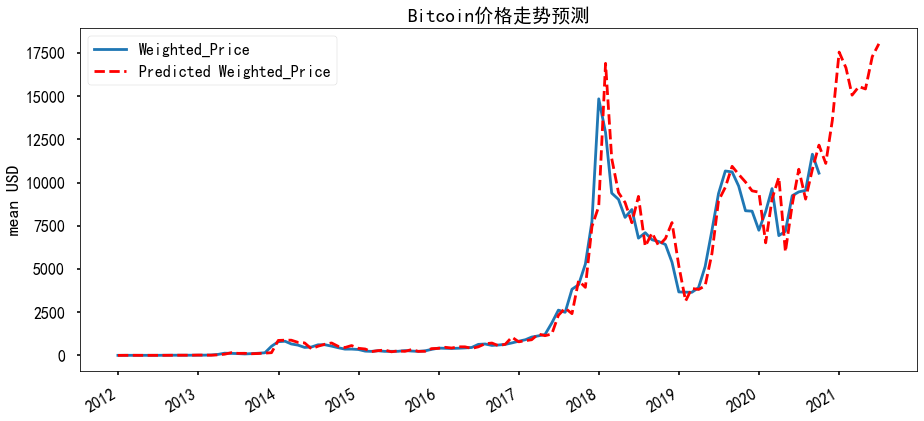

In [36]:
df_month2 = df_month[['Weighted_Price']]
#date_list = [datetime(2020, 10, 14), datetime(2020, 11, 14), datetime(2020, 12, 14), datetime(2021, 1, 14), 
#             datetime(2021, 2, 14), datetime(2021, 3, 14), datetime(2021, 4, 14), datetime(2021, 5, 14),
#             datetime(2021, 6, 14)]
date_list = [datetime(2020, 9, 30),datetime(2020, 10, 31), datetime(2020, 11, 30), datetime(2020, 12, 31), datetime(2021, 1, 31),
             datetime(2021, 2, 28),datetime(2021, 3, 31),  datetime(2021, 4, 30),  datetime(2021, 5, 31),  datetime(2021, 6, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=120), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin价格走势预测')
plt.ylabel('mean USD')
plt.show()